In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'bit', 'bit64', 'curl', 'gert', 'jsonlite', 'openssl', 'profvis'



In [2]:
library(DESeq2)
library(dplyr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading r

In [ ]:
file_paths <- list.files(pattern = "*..ReadsPerGene.out.tab")
file_paths

[1] "N2_day1_rep1.ReadsPerGene.out.tab" "N2_day1_rep2.ReadsPerGene.out.tab"
[3] "N2_day1_rep3.ReadsPerGene.out.tab" "N2_day7_rep1.ReadsPerGene.out.tab"
[5] "N2_day7_rep2.ReadsPerGene.out.tab" "N2_day7_rep3.ReadsPerGene.out.tab"

In [ ]:
# Function to read the STAR ReadsPerGene.out.tab file
read_star_file <- function(file_path) {
  # Read the file
  df <- read.table(file_path, header = FALSE, stringsAsFactors = FALSE)

  # Keep only the first (gene) and second (unstranded counts) columns
  df <- df %>% select(V1, V2)

  # Rename the columns for clarity (GeneID and counts for this sample)
  colnames(df) <- c("GeneID", gsub(".ReadsPerGene.out.tab", "", basename(file_path)))

  return(df)
}

# Read all files into a list of data frames
list_of_dfs <- lapply(file_paths, read_star_file)

# Merge all data frames by the GeneID column
merged_df <- Reduce(function(x, y) merge(x, y, by = "GeneID"), list_of_dfs)

merged_df <- merged_df[-c(1:4), ]

# Check the first few rows of the combined data frame
head(merged_df)

# Optionally, write the combined data frame to a CSV file
write.csv(merged_df, "combined_gene_counts.csv", row.names = FALSE)

,GeneID,N2_day1_rep1,N2_day1_rep2,N2_day1_rep3,N2_day7_rep1,N2_day7_rep2,N2_day7_rep3
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
5,WBGene00000001,3227,2168,2589,5659,2619,5239
6,WBGene00000002,270,203,266,355,191,425
7,WBGene00000003,341,415,411,387,255,499
8,WBGene00000004,584,438,518,1028,541,888
9,WBGene00000005,383,395,483,119,65,189
10,WBGene00000006,343,344,334,206,114,220


In [ ]:
rownames(merged_df) = merged_df$GeneID
merged_df$GeneID = NULL


In [ ]:
coldata <- colnames(merged_df)
coldata_df <- cbind(group = gsub("_rep\\d", "", coldata))
rownames(coldata_df) = coldata
coldata_df

,group
N2_day1_rep1,N2_day1
N2_day1_rep2,N2_day1
N2_day1_rep3,N2_day1
N2_day7_rep1,N2_day7
N2_day7_rep2,N2_day7
N2_day7_rep3,N2_day7


In [ ]:
dds <- DESeqDataSetFromMatrix(countData = merged_df,
                              colData = coldata_df,
                              design= ~ group)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [ ]:
dds <- DESeq(dds)
res <- results(dds)
res

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): group N2 day7 vs N2 day1 
Wald test p-value: group N2 day7 vs N2 day1 
DataFrame with 46926 rows and 6 columns
                baseMean log2FoldChange     lfcSE      stat      pvalue
               <numeric>      <numeric> <numeric> <numeric>   <numeric>
WBGene00000001  3380.314      0.4320800  0.136502  3.165370 1.54886e-03
WBGene00000002   272.816      0.0620929  0.165747  0.374626 7.07939e-01
WBGene00000003   381.405     -0.3623262  0.199673 -1.814594 6.95864e-02
WBGene00000004   638.936      0.3698102  0.151232  2.445312 1.44727e-02
WBGene00000005   282.439     -2.1244976  0.227771 -9.327337 1.08564e-20
...                  ...            ...       ...       ...         ...
WBGene00306078  0.566369       0.947326  3.076775  0.307896 7.58162e-01
WBGene00306080  0.243919       1.429602  4.042905  0.353608 7.23633e-01
WBGene00306081 27.265033      -3.108820  0.627823 -4.951747 7.35501e-07
WBGene00306121 14.219195      -0.210100  0.691162 -0.303981 7.61142e-01
W

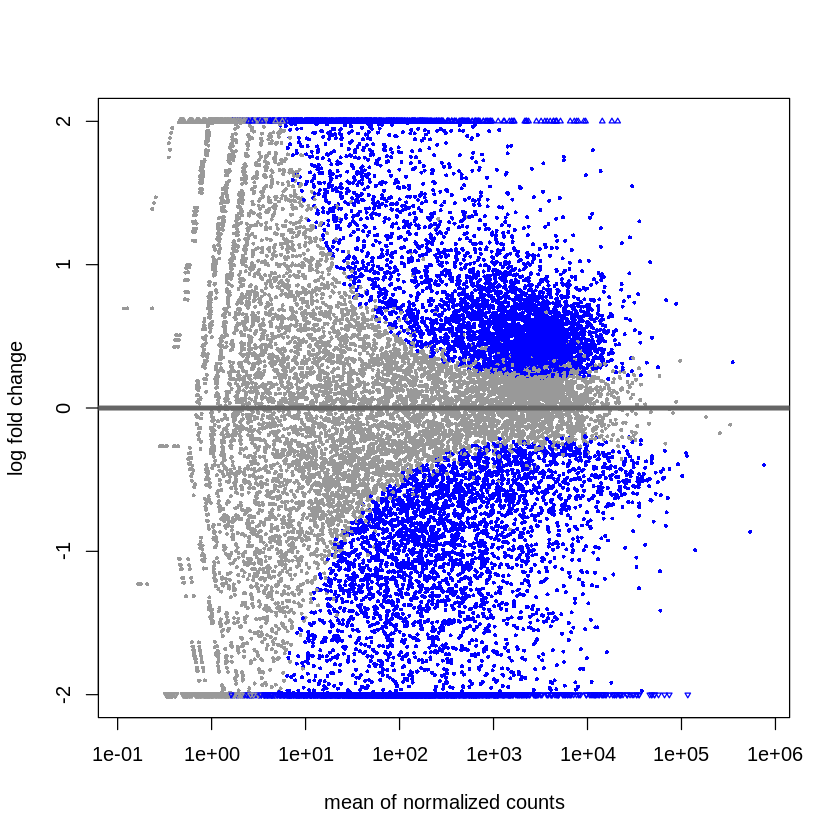

In [ ]:
plotMA(res, ylim=c(-2,2))


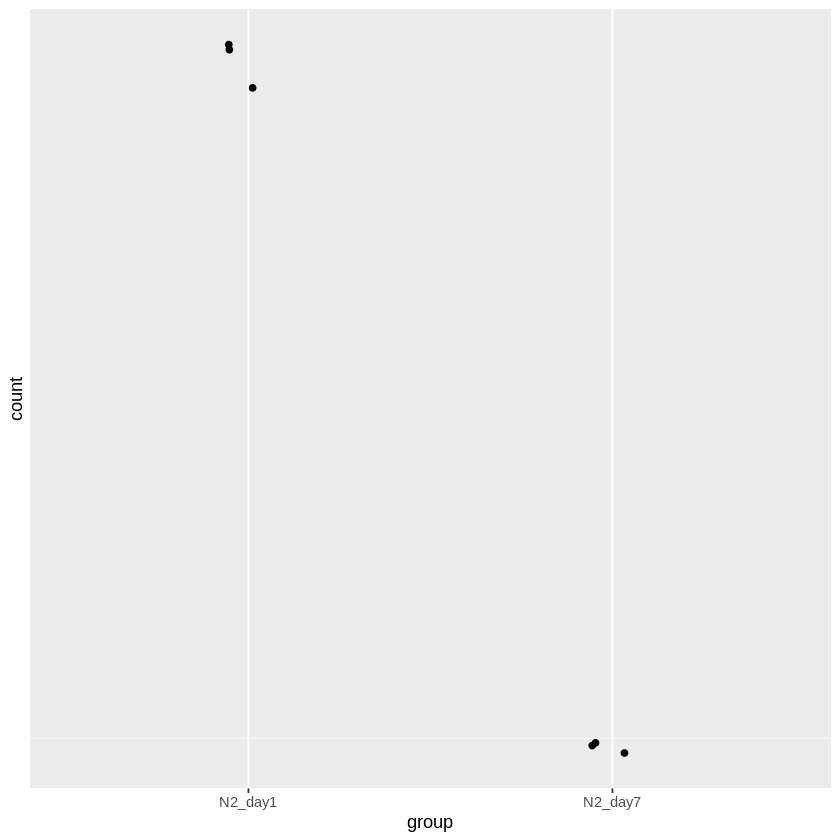

In [ ]:
d <- plotCounts(dds, gene=which.min(res$padj), intgroup="group",
                returnData=TRUE)
library("ggplot2")
ggplot(d, aes(x=group, y=count)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  scale_y_log10(breaks=c(25,100,400))

In [ ]:
vsd <- vst(dds, blind=FALSE)

using ntop=500 top features by variance



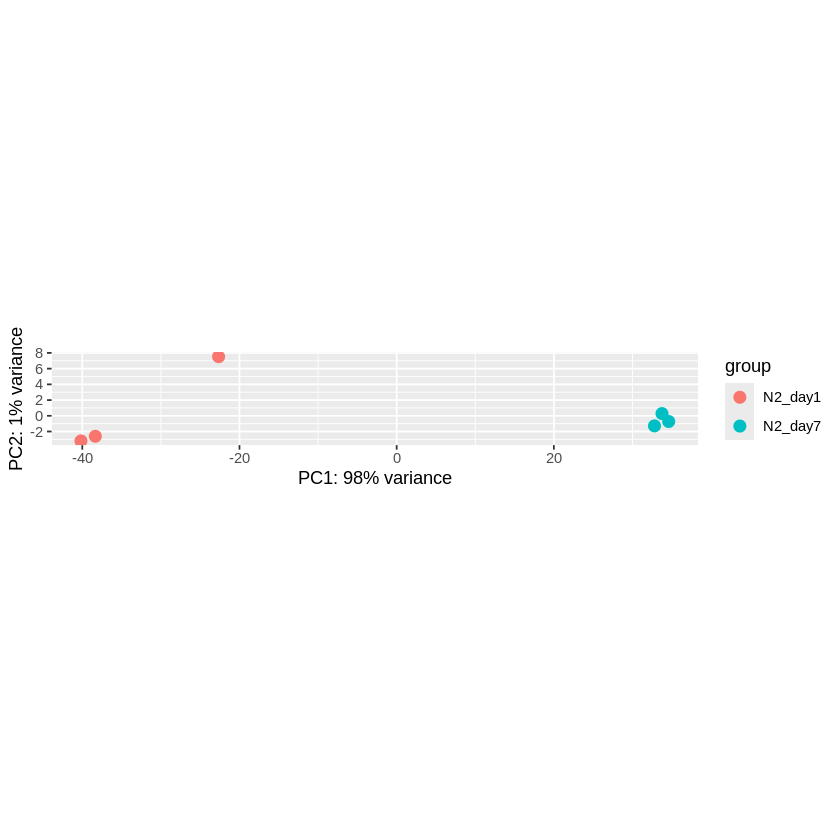

In [ ]:
plotPCA(vsd, intgroup = c("group"))